In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import FiShPy.FiSh as FS
%matplotlib inline

In [3]:
os.chdir('../../Data/Post, combined/combined/')
data = {}
locations = ['centar', 'gazibaba', 'karpos', 'kicevo', 'kumanovo', 'lisice', 'miladinovci', 'tetovo']
for loc in locations:
    data[loc] = pd.read_csv(loc + '.csv')
    data[loc]['time'] = pd.to_datetime(data[loc]['time'], infer_datetime_format=True)

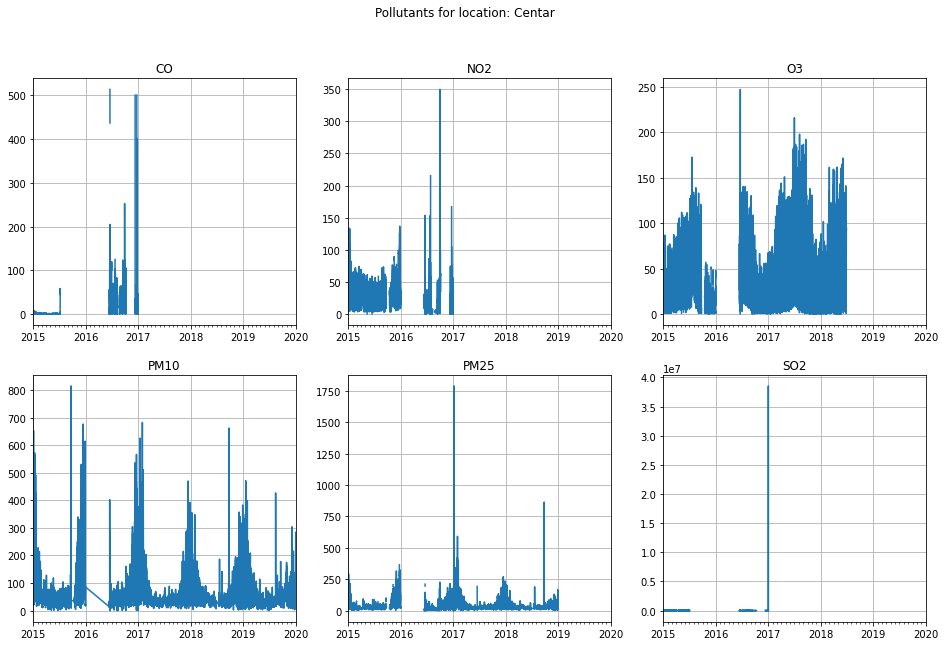

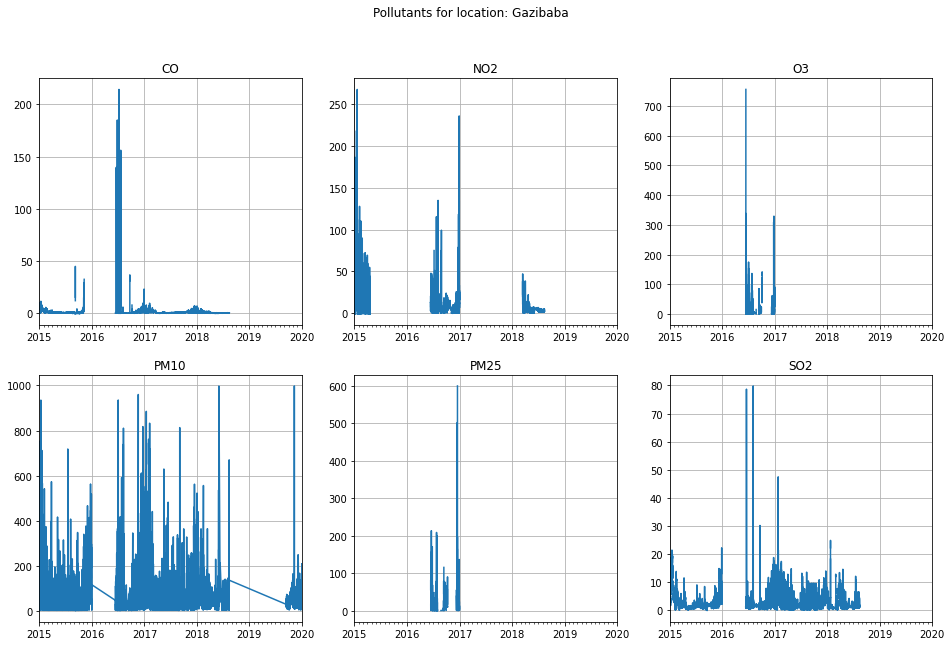

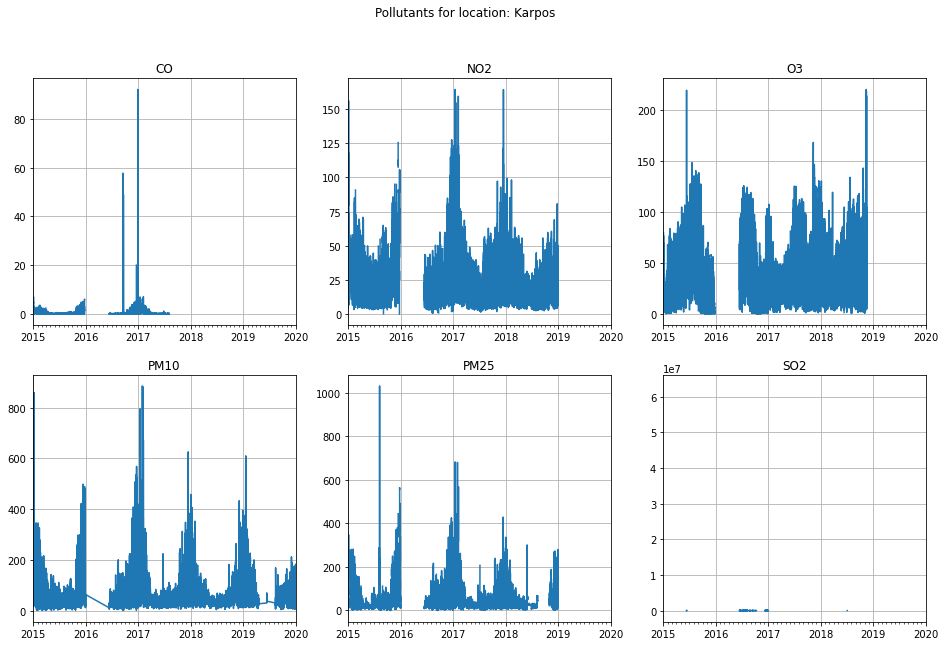

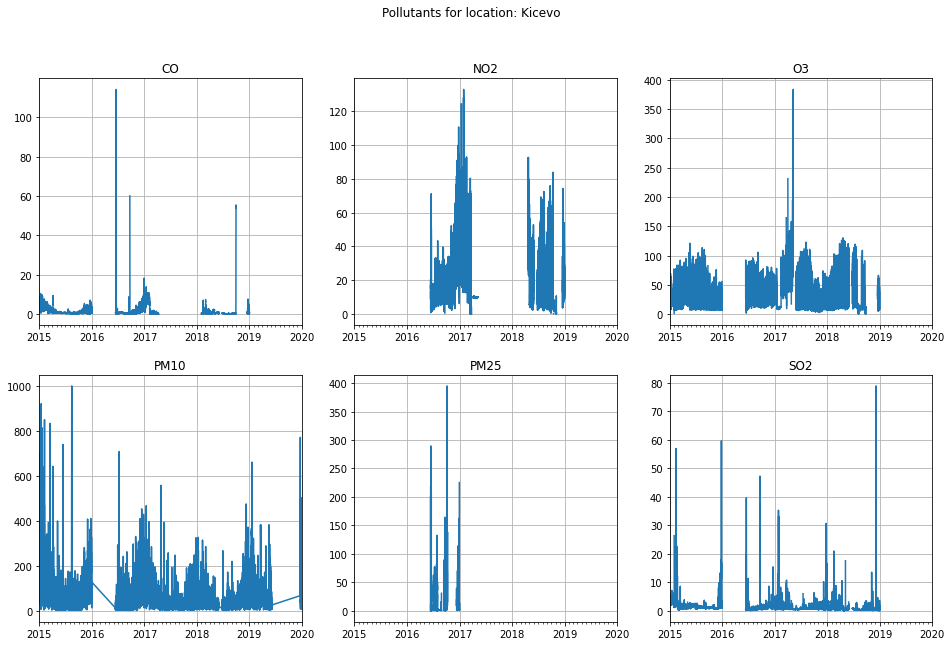

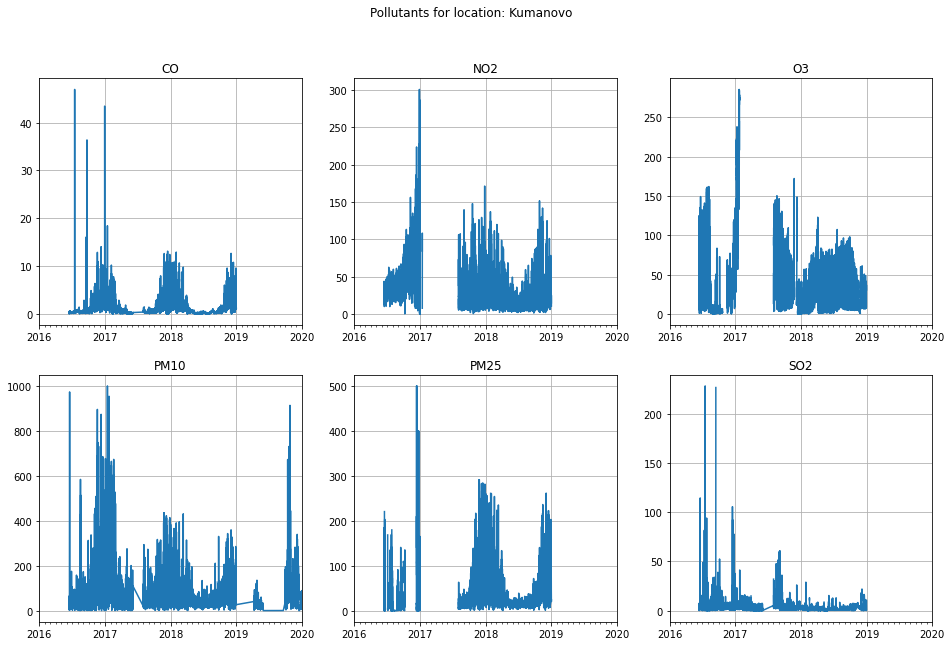

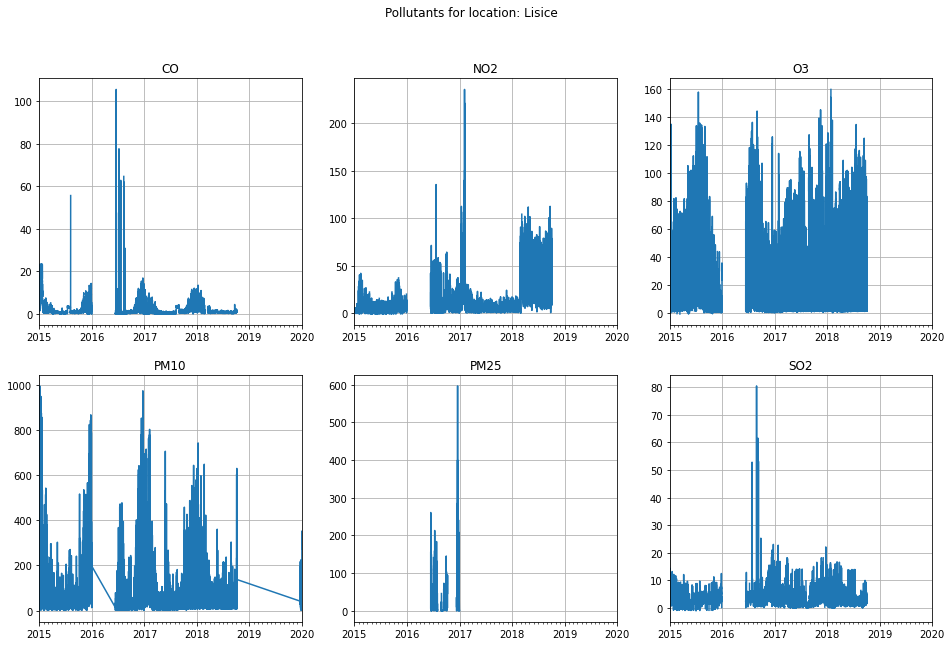

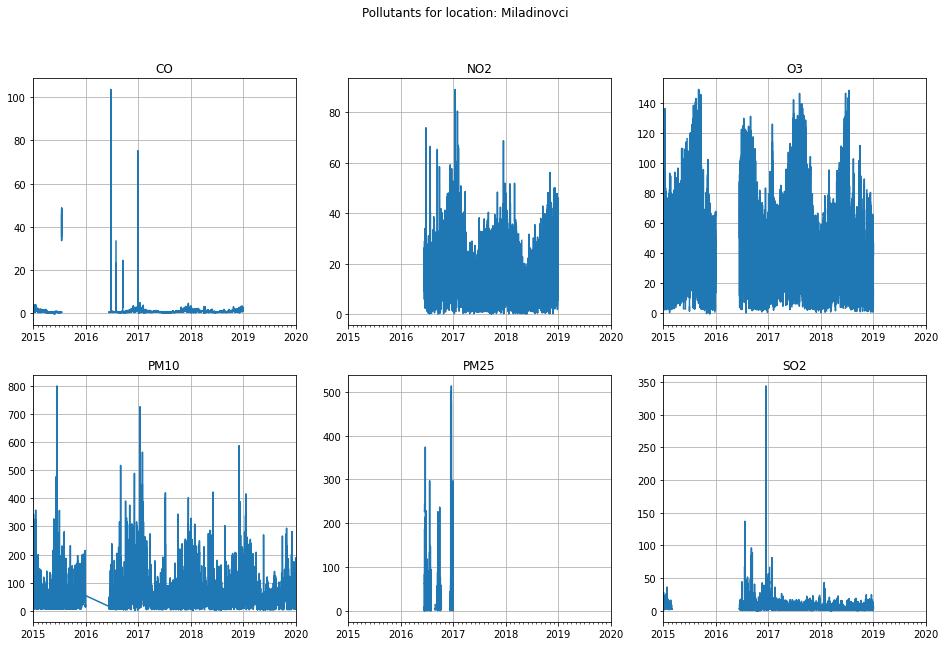

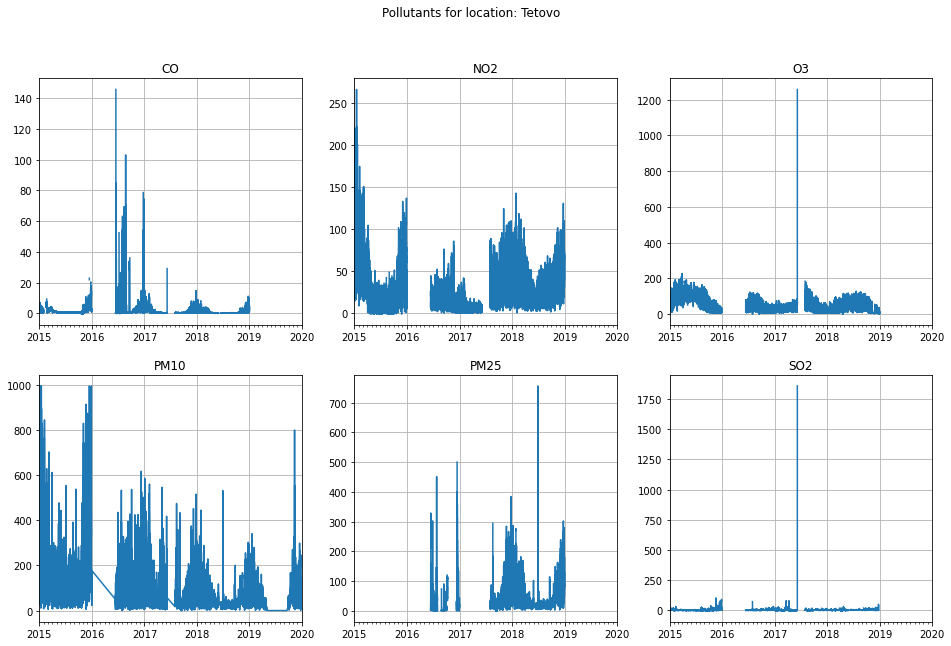

In [45]:
pollutants = ['CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
for loc in locations:
    fig = plt.figure(figsize=(16,10))
    fig.subplots(2,3)
    fig.suptitle("Pollutants for location: " + loc.capitalize())
    for i, p in enumerate(pollutants):
        ax = plt.subplot(2,3,i+1)
        # format the ticks
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.xaxis.set_minor_locator(months)

        # round to nearest years.
        datemin = np.datetime64(data[loc]['time'].iloc[0], 'Y')
        datemax = np.datetime64(data[loc]['time'].iloc[-1], 'Y')
        ax.set_xlim(datemin, datemax)

        # format the coords message box
        ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
        ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
        ax.grid(True)
        
        plt.plot(data[loc]['time'],data[loc][p])
        plt.title(p)
plt.show()

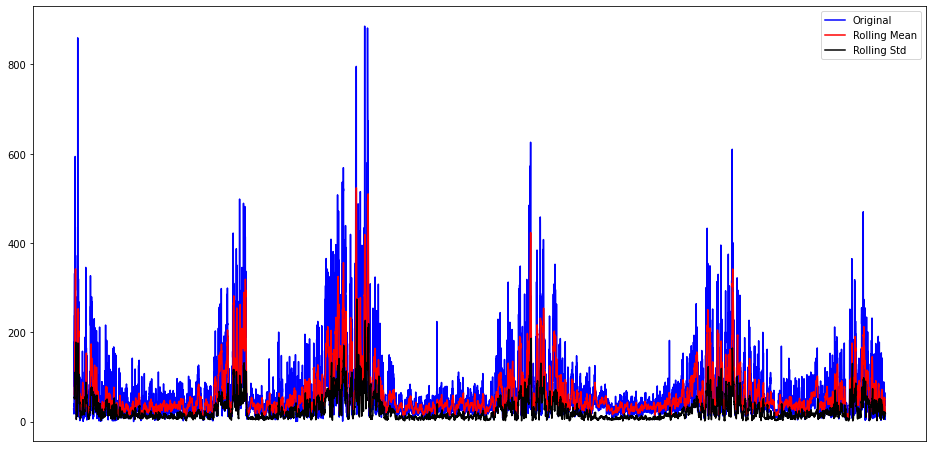

In [54]:
rolmean = data['karpos']['PM10'].rolling(window=30).mean()
rolstd = data['karpos']['PM10'].rolling(window=30).std()

fig = plt.figure(figsize=(16,8))
orig = plt.plot(data['karpos']['PM10'], color='blue', label='Original')
orig = plt.plot(rolmean, color='red', label='Rolling Mean')
orig = plt.plot(rolstd, color='black', label='Rolling Std')

plt.xticks([])
plt.legend(loc='best')
plt.show()

In [59]:
# Stationarity test, not working
from statsmodels.tsa.stattools import adfuller
from functools import reduce

for loc in locations:
    for p in pollutants:
        if reduce(lambda a,b: a and b, data[loc][p].isna()):
            print("Results of Dickey-Fuller Test on {} pollutant at {} location".format(p, loc))
            dftest = adfuller(data[loc][p], autolag='AIC')

            dfoutput = pd.Series(dftest[:4], index=['Test Statistic', 'p-value', 
                                                    '#Lags used', '#Observations used'])
            for k, v in dftest[4].items():
                dfoutput['Critical Value (%s)'%k] = v

            print(dfoutput + '/n')

# Clustering

In [20]:
fsp = pd.DataFrame(columns=['loc','sep','fim'])
sep, fim = [], []
for loc in locations:
    h = FS.dpik(data[loc]['PM10'])
    SEP, FIM, FSC = FS.SEP_FIM(data[loc]['PM10'], h, log_trsf=True)
    sep.append(SEP)
    fim.append(FIM)
fsp['loc'] = locations
fsp['sep'] = sep
fsp['fim'] = fim
fsp.set_index('loc', inplace=True)
display(fsp)

,sep,fim
loc,,
centar,NaN,NaN
gazibaba,NaN,NaN
karpos,1299.462039,0.005243
kicevo,1112.933630,0.025625
kumanovo,NaN,NaN
lisice,NaN,NaN
miladinovci,1316.796931,0.014323
tetovo,NaN,NaN
